<a href="https://colab.research.google.com/github/Sharath-11507563/sharath_INFO5731_-Fall2021/blob/main/Final_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
import nltk, re, string
import pandas as pd
import io
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import seaborn as sn

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [158]:
from google.colab import files 
uploaded = files.upload()

Saving Final_comments_with_no_aspects.csv to Final_comments_with_no_aspects (4).csv


In [159]:
data = pd.read_csv(io.BytesIO(uploaded['Final_comments_with_no_aspects.csv']))
data.head(5)

,Docket_Id,Comment_Id,Comment,Annotator 1,Annotator 2,Annotator 3
0,FDA-2010-D-0277,FDA-2010-D-0277-0007,I am urging the support of FDA 2010-D-0277-000...,Positive,positive,positive
1,FDA-2010-D-0277,FDA-2010-D-0277-0008,The Family Smoking Prevention and Tobacco Cont...,Positive,negative,negative
2,FDA-2010-D-0277,FDA-2010-D-0277-0010,As the director of a state tobacco control pro...,Positive,positive,positive
3,FDA-2010-D-0277,FDA-2010-D-0277-0011,"Please, for the protection, health and welfare...",Positive,negative,positive
4,FDA-2010-D-0277,FDA-2010-D-0277-0013,"Cigars, little cigars, and pipe tobacco can ho...",Positive,negative,positive


In [160]:
data['Number of Sentences'] = data['Comment'].apply(lambda x: len(str(x).split(".")))
data['Number of Words'] = data['Comment'].apply(lambda x: len(str(x).split(" ")))
data['Number of Characters'] = data['Comment'].str.len()
def avg_word_length(sentence):
  words = sentence.split()
  if len(words) != 0:
    return(sum(len(word) for word in words)/len(words))
  else:
    return None
data['Average Word Length'] = data['Comment'].apply(lambda x: avg_word_length(x))
stop = stopwords.words('english')
data['Number of Stopwords'] = data['Comment'].apply(lambda x: len([x for x in x.split() if x in stop]))
data['Number of numerics'] = data['Comment'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
data['Number of upper case words'] = data['Comment'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
data.head(5)

,Docket_Id,Comment_Id,Comment,Annotator 1,Annotator 2,Annotator 3,Number of Sentences,Number of Words,Number of Characters,Average Word Length,Number of Stopwords,Number of numerics,Number of upper case words
0,FDA-2010-D-0277,FDA-2010-D-0277-0007,I am urging the support of FDA 2010-D-0277-000...,Positive,positive,positive,5,78,462,5.133333,32,0,4
1,FDA-2010-D-0277,FDA-2010-D-0277-0008,The Family Smoking Prevention and Tobacco Cont...,Positive,negative,negative,6,146,904,5.345070,46,3,3
2,FDA-2010-D-0277,FDA-2010-D-0277-0010,As the director of a state tobacco control pro...,Positive,positive,positive,4,75,495,5.613333,25,0,1
3,FDA-2010-D-0277,FDA-2010-D-0277-0011,"Please, for the protection, health and welfare...",Positive,negative,positive,4,64,362,4.901639,23,0,2
4,FDA-2010-D-0277,FDA-2010-D-0277-0013,"Cigars, little cigars, and pipe tobacco can ho...",Positive,negative,positive,3,28,180,5.884615,10,0,1


In [161]:
print('The maximum,mimimum and average Number of sentences are',data['Number of Sentences'].max(),',',data['Number of Sentences'].min(),',',data['Number of Sentences'].mean())
print('The maximum,minimum and average Number of Words are',data['Number of Words'].max(),',',data['Number of Words'].min(),',',data['Number of Words'].mean())
print('The maximum,mimimum and average Number of Characters are',data['Number of Characters'].max(),',',data['Number of Characters'].min(),',',data['Number of Characters'].mean())
print('The maximum,mimimum and average of Average Word Length are',data['Average Word Length'].max(),',',data['Average Word Length'].min(),',',data['Average Word Length'].mean())
print('The maximum,mimimum and average Number of Stopwords are',data['Number of Stopwords'].max(),',',data['Number of Stopwords'].min(),',',data['Number of Stopwords'].mean())
print('The maximum,mimimum and average Number of numerics are',data['Number of numerics'].max(),',',data['Number of numerics'].min(),',',data['Number of numerics'].mean())
print('The maximum,mimimum and average Number of upper case words are',data['Number of upper case words'].max(),',',data['Number of upper case words'].min(),',',data['Number of upper case words'].mean())

The maximum,mimimum and average Number of sentences are 111 , 1 , 9.434869739478957
The maximum,minimum and average Number of Words are 903 , 4 , 151.374749498998
The maximum,mimimum and average Number of Characters are 5000 , 14 , 905.0040080160321
The maximum,mimimum and average of Average Word Length are 14.2 , 2.5 , 5.004948179446248
The maximum,mimimum and average Number of Stopwords are 386 , 0 , 58.90581162324649
The maximum,mimimum and average Number of numerics are 11 , 0 , 0.6863727454909819
The maximum,mimimum and average Number of upper case words are 226 , 0 , 5.218436873747495


In [162]:
stopwords_list = stopwords.words('english') # importing stopwords
punctuations_list = string.punctuation # get punctuations
lemmatizer = WordNetLemmatizer() # initialize word lemmatizer

def filter_annotation(annotator):
  (annotator1, annotator2, annotator3) = annotator
  if annotator1.lower()[:3]=='pos' and annotator2.lower()[:3]=='pos' and annotator3.lower()[:3]=='pos': return "Positive"
  elif annotator1.lower()[:3]=='neg' and annotator2.lower()[:3]=='neg' and annotator3.lower()[:3]=='neg': return "Negative"
  elif annotator1.lower()[:3]=='neu' and annotator2.lower()[:3]=='neu' and annotator3.lower()[:3]=='neu': return "Neutral"
  elif (annotator1.lower()[:3]=='pos' and annotator2.lower()[:3]=='pos') or  (annotator2.lower()[:3]=='pos' and annotator3.lower()[:3]=='pos') or (annotator3.lower()[:3]=='pos' and annotator1.lower()[:3]=='pos'): return "Positive"
  elif (annotator1.lower()[:3]=='neg' and annotator2.lower()[:3]=='neg') or (annotator2.lower()[:3]=='neg' and annotator3.lower()[:3]=='neg') or (annotator3.lower()[:3]=='neg' and annotator1.lower()[:3]=='neg'): return "Negative"
  elif (annotator1.lower()[:3]=='neu' and annotator2.lower()[:3]=='neu') or (annotator2.lower()[:3]=='neu' and annotator3.lower()[:3]=='neu') or (annotator3.lower()[:3]=='neu' and annotator1.lower()[:3]=='neu'): return "Neutral"
  else: return 'Neutral'

def preprocessing(text):
    """
    This function will clean the given text
    """
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower())
    text = text + " ".join(emoticons).replace('-', '')
    tokenize_text = [lemmatizer.lemmatize(word) for word in nltk.tokenize.word_tokenize(text) 
                     if (word not in stopwords_list) and (word not in punctuations_list) and (len(word)>=2) and (word.isalpha())]
    return " ".join(tokenize_text)

In [163]:
data["Comment"] = data["Comment"].apply(str)
data["Clean_Comment"] = data["Comment"].apply(preprocessing)
data.head(5)

,Docket_Id,Comment_Id,Comment,Annotator 1,Annotator 2,Annotator 3,Number of Sentences,Number of Words,Number of Characters,Average Word Length,Number of Stopwords,Number of numerics,Number of upper case words,Clean_Comment
0,FDA-2010-D-0277,FDA-2010-D-0277-0007,I am urging the support of FDA 2010-D-0277-000...,Positive,positive,positive,5,78,462,5.133333,32,0,4,urging support fda support effort protecting c...
1,FDA-2010-D-0277,FDA-2010-D-0277-0008,The Family Smoking Prevention and Tobacco Cont...,Positive,negative,negative,6,146,904,5.345070,46,3,3,family smoking prevention tobacco control act ...
2,FDA-2010-D-0277,FDA-2010-D-0277-0010,As the director of a state tobacco control pro...,Positive,positive,positive,4,75,495,5.613333,25,0,1,director state tobacco control program would s...
3,FDA-2010-D-0277,FDA-2010-D-0277-0011,"Please, for the protection, health and welfare...",Positive,negative,positive,4,64,362,4.901639,23,0,2,please protection health welfare child free to...
4,FDA-2010-D-0277,FDA-2010-D-0277-0013,"Cigars, little cigars, and pipe tobacco can ho...",Positive,negative,positive,3,28,180,5.884615,10,0,1,cigar little cigar pipe tobacco hook young peo...


In [164]:
annotator = list(zip(data["Annotator 1"], data["Annotator 2"], data["Annotator 3"]))
data["Annotator"] = list(map(filter_annotation, annotator))

In [165]:
def absolute_sentiment(sentiment):
  if sentiment=="Positive": return 1
  elif sentiment=="Negative": return -1
  else: return 0
  
data['Triple_Sentiments'] = data['Annotator'].apply(absolute_sentiment)
data['Single_Sentiments'] = data['Annotator 1'].apply(absolute_sentiment)
data.head(5)

,Docket_Id,Comment_Id,Comment,Annotator 1,Annotator 2,Annotator 3,Number of Sentences,Number of Words,Number of Characters,Average Word Length,Number of Stopwords,Number of numerics,Number of upper case words,Clean_Comment,Annotator,Triple_Sentiments,Single_Sentiments
0,FDA-2010-D-0277,FDA-2010-D-0277-0007,I am urging the support of FDA 2010-D-0277-000...,Positive,positive,positive,5,78,462,5.133333,32,0,4,urging support fda support effort protecting c...,Positive,1,1
1,FDA-2010-D-0277,FDA-2010-D-0277-0008,The Family Smoking Prevention and Tobacco Cont...,Positive,negative,negative,6,146,904,5.345070,46,3,3,family smoking prevention tobacco control act ...,Negative,-1,1
2,FDA-2010-D-0277,FDA-2010-D-0277-0010,As the director of a state tobacco control pro...,Positive,positive,positive,4,75,495,5.613333,25,0,1,director state tobacco control program would s...,Positive,1,1
3,FDA-2010-D-0277,FDA-2010-D-0277-0011,"Please, for the protection, health and welfare...",Positive,negative,positive,4,64,362,4.901639,23,0,2,please protection health welfare child free to...,Positive,1,1
4,FDA-2010-D-0277,FDA-2010-D-0277-0013,"Cigars, little cigars, and pipe tobacco can ho...",Positive,negative,positive,3,28,180,5.884615,10,0,1,cigar little cigar pipe tobacco hook young peo...,Positive,1,1


#Triple annotation models

In [167]:
comment = data["Clean_Comment"]
sentiment = data["Triple_Sentiments"]

In [168]:
X_train, X_test, Y_train, Y_test = train_test_split(comment,sentiment, test_size = 0.3, random_state = 60,shuffle=True, stratify=sentiment)

Accuracy:  0.5933333333333334
Navie Bayes accuracy on train data:  76 %
Navie Bayes accuracy on test data:  59 %
              precision    recall  f1-score   support

          -1       0.90      0.62      0.73       198
           0       0.07      0.62      0.12         8
           1       0.56      0.53      0.55        94

    accuracy                           0.59       300
   macro avg       0.51      0.59      0.47       300
weighted avg       0.77      0.59      0.66       300

The Average Accuracy score for a ten-fold cross-validations is: 0.5351717171717172


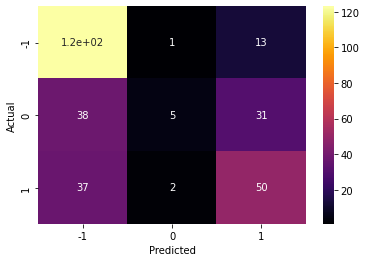

In [170]:
nb_pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('model', MultinomialNB()),])
nb_pipeline.fit(X_train,Y_train)

Y_pred = nb_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print('Accuracy: ',metrics.accuracy_score(Y_test, Y_pred))
print("Navie Bayes accuracy on train data: ", round(nb_pipeline.score(X_train,Y_train)*100), '%')
print("Navie Bayes accuracy on test data: ", round(nb_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(nb_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean())

SVM accuracy on train data:  99 %
SVM accuracy on test data:  63 %
              precision    recall  f1-score   support

          -1       0.77      0.83      0.80       127
           0       0.39      0.42      0.41        69
           1       0.62      0.53      0.57       104

    accuracy                           0.63       300
   macro avg       0.59      0.59      0.59       300
weighted avg       0.63      0.63      0.63       300

The Average Accuracy score for a ten-fold cross-validations is: 0.5652525252525253


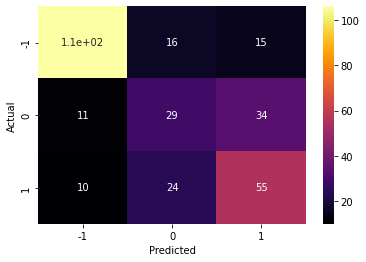

In [171]:
svm_pipeline = Pipeline([('tfidf', TfidfVectorizer()),('model', SGDClassifier()),])
svm_pipeline.fit(X_train,Y_train)

Y_pred = svm_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("SVM accuracy on train data: ", round(svm_pipeline.score(X_train,Y_train)*100), '%')
print("SVM accuracy on test data: ", round(svm_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(svm_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean())

Decision Tree accuracy on train data:  99 %
Decision Tree accuracy on test data:  54 %
              precision    recall  f1-score   support

          -1       0.66      0.74      0.69       122
           0       0.38      0.35      0.36        80
           1       0.49      0.45      0.47        98

    accuracy                           0.54       300
   macro avg       0.51      0.51      0.51       300
weighted avg       0.53      0.54      0.53       300

The Average Accuracy score for a ten-fold cross-validations is: 0.5191818181818182


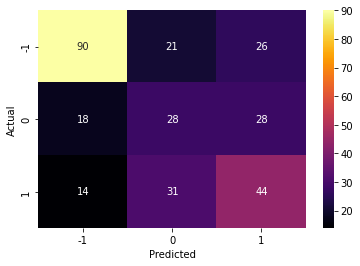

In [172]:
DT_pipeline = Pipeline([('tfidf', TfidfVectorizer()),('model', DecisionTreeClassifier()),])
DT_pipeline.fit(X_train,Y_train)

Y_pred = DT_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Decision Tree accuracy on train data: ", round(DT_pipeline.score(X_train,Y_train)*100), '%')
print("Decision Tree accuracy on test data: ", round(DT_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(DT_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean())

Random Forest accuracy on train data:  99 %
Random Forest accuracy on test data:  62 %
              precision    recall  f1-score   support

          -1       0.80      0.76      0.78       145
           0       0.15      0.46      0.22        24
           1       0.73      0.50      0.59       131

    accuracy                           0.62       300
   macro avg       0.56      0.57      0.53       300
weighted avg       0.72      0.62      0.65       300

The Average Accuracy score for a ten-fold cross-validations is: 0.6053535353535354


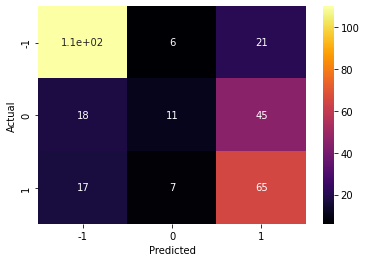

In [173]:
RF_pipeline = Pipeline([('tfidf', TfidfVectorizer()),('model', RandomForestClassifier()),])
RF_pipeline.fit(X_train,Y_train)

Y_pred = RF_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Random Forest accuracy on train data: ", round(RF_pipeline.score(X_train,Y_train)*100), '%')
print("Random Forest accuracy on test data: ", round(RF_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(RF_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean())

Logestic Regression accuracy on train data:  93 %
Logestic Regression accuracy on test data:  64 %
              precision    recall  f1-score   support

          -1       0.81      0.77      0.79       144
           0       0.20      0.45      0.28        33
           1       0.74      0.54      0.62       123

    accuracy                           0.64       300
   macro avg       0.58      0.59      0.56       300
weighted avg       0.72      0.64      0.67       300

The Average Accuracy score for a ten-fold cross-validations is: 0.5753232323232322


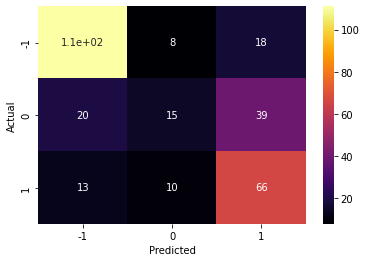

In [174]:
LR_pipeline = Pipeline([('tfidf', TfidfVectorizer()),('model', LogisticRegression()),])
LR_pipeline.fit(X_train,Y_train)

Y_pred = LR_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Logestic Regression accuracy on train data: ", round(LR_pipeline.score(X_train,Y_train)*100), '%')
print("Logestic Regression accuracy on test data: ", round(LR_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(LR_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean())

#Single annotation models

In [176]:
comment = data["Clean_Comment"]
sentiment = data["Single_Sentiments"]

In [179]:
X_train, X_test, Y_train, Y_test = train_test_split(comment,sentiment, test_size = 0.3, random_state = 60,shuffle=True)

Navie Bayes accuracy on train data:  78 %
Navie Bayes accuracy on test data:  60 %
              precision    recall  f1-score   support

          -1       0.89      0.64      0.74       212
           0       0.27      0.53      0.36        38
           1       0.33      0.50      0.40        50

    accuracy                           0.60       300
   macro avg       0.50      0.55      0.50       300
weighted avg       0.72      0.60      0.64       300

The Average Accuracy score for a ten-fold cross-validations is: 0.5201919191919192


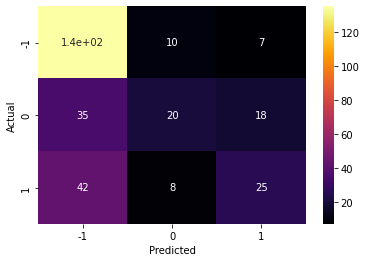

In [180]:
nb_pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('model', MultinomialNB()),])
nb_pipeline.fit(X_train,Y_train)

Y_pred = nb_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Navie Bayes accuracy on train data: ", round(nb_pipeline.score(X_train,Y_train)*100), '%')
print("Navie Bayes accuracy on test data: ", round(nb_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(nb_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean())

SVM accuracy on train data:  99 %
SVM accuracy on test data:  62 %
              precision    recall  f1-score   support

          -1       0.75      0.83      0.79       124
           0       0.41      0.39      0.40        77
           1       0.61      0.55      0.57        99

    accuracy                           0.62       300
   macro avg       0.59      0.59      0.59       300
weighted avg       0.62      0.62      0.62       300

The Average Accuracy score for a ten-fold cross-validations is: 0.5582424242424242


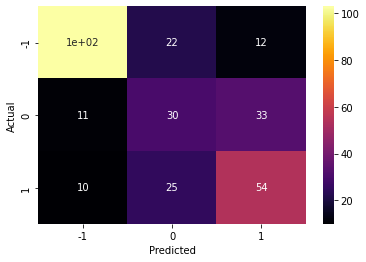

In [178]:
svm_pipeline = Pipeline([('tfidf', TfidfVectorizer()),('model', SGDClassifier()),])
svm_pipeline.fit(X_train,Y_train)

Y_pred = svm_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("SVM accuracy on train data: ", round(svm_pipeline.score(X_train,Y_train)*100), '%')
print("SVM accuracy on test data: ", round(svm_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(svm_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean())

Decision Tree accuracy on train data:  100 %
Decision Tree accuracy on test data:  58 %
              precision    recall  f1-score   support

          -1       0.73      0.75      0.74       148
           0       0.47      0.44      0.45        77
           1       0.40      0.40      0.40        75

    accuracy                           0.58       300
   macro avg       0.53      0.53      0.53       300
weighted avg       0.58      0.58      0.58       300

The Average Accuracy score for a ten-fold cross-validations is: 0.5562323232323232


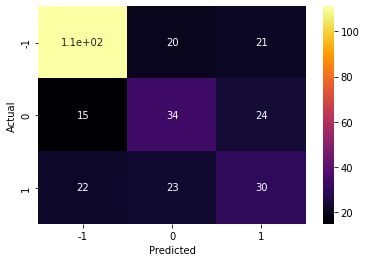

In [182]:
DT_pipeline = Pipeline([('tfidf', TfidfVectorizer()),('model', DecisionTreeClassifier()),])
DT_pipeline.fit(X_train,Y_train)

Y_pred = DT_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Decision Tree accuracy on train data: ", round(DT_pipeline.score(X_train,Y_train)*100), '%')
print("Decision Tree accuracy on test data: ", round(DT_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(DT_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean())

Random Forest accuracy on train data:  100 %
Random Forest accuracy on test data:  64 %
              precision    recall  f1-score   support

          -1       0.82      0.77      0.79       163
           0       0.40      0.48      0.44        60
           1       0.51      0.49      0.50        77

    accuracy                           0.64       300
   macro avg       0.58      0.58      0.58       300
weighted avg       0.66      0.64      0.65       300

The Average Accuracy score for a ten-fold cross-validations is: 0.6083030303030303


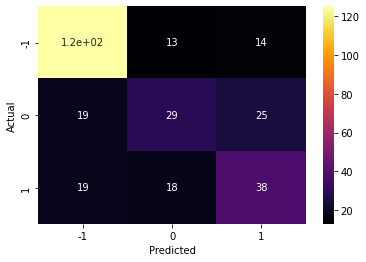

In [183]:
RF_pipeline = Pipeline([('tfidf', TfidfVectorizer()),('model', RandomForestClassifier()),])
RF_pipeline.fit(X_train,Y_train)

Y_pred = RF_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Random Forest accuracy on train data: ", round(RF_pipeline.score(X_train,Y_train)*100), '%')
print("Random Forest accuracy on test data: ", round(RF_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(RF_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean())

Logestic Regression accuracy on train data:  91 %
Logestic Regression accuracy on test data:  68 %
              precision    recall  f1-score   support

          -1       0.83      0.80      0.82       157
           0       0.41      0.55      0.47        55
           1       0.63      0.53      0.58        88

    accuracy                           0.68       300
   macro avg       0.62      0.63      0.62       300
weighted avg       0.69      0.68      0.68       300

The Average Accuracy score for a ten-fold cross-validations is: 0.5982828282828283


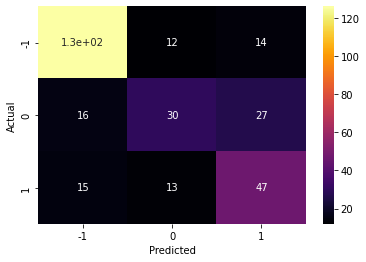

In [184]:
LR_pipeline = Pipeline([('tfidf', TfidfVectorizer()),('model', LogisticRegression()),])
LR_pipeline.fit(X_train,Y_train)

Y_pred = LR_pipeline.predict(X_test)

confusion_matrix = pd.crosstab(Y_test, Y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True, cmap='inferno')
print("Logestic Regression accuracy on train data: ", round(LR_pipeline.score(X_train,Y_train)*100), '%')
print("Logestic Regression accuracy on test data: ", round(LR_pipeline.score(X_test,Y_test)*100), '%')
print(classification_report(Y_pred, Y_test))
print('The Average Accuracy score for a ten-fold cross-validations is:',cross_val_score(LR_pipeline, comment, sentiment, cv=10, scoring ='accuracy').mean())